<a href="https://colab.research.google.com/github/margueriti/crispy-invention/blob/main/Good_Research_Practices_Tutorial_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tutorial 6: Implementing the Analysis**

> Indented block

> Indented block




**Week 1, Day 1, Good Research Practices**

**Content creators:** Marguerite Brown, Yuxin Zhou

**Content reviewers:** TBD

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

###**Code and Data Sources**

Code for this tutorial is originally produced by Yuxin Zhou.

Data from the following sources are used in this tutorial:

CO<sub>2</sub>: Bereiter, B., Eggleston, S., Schmitt, J., Nehrbass-Ahles, C., Stocker, T.F., Fischer, H., Kipfstuhl, S., Chappellaz, J., 2015. Revision of the EPICA Dome C CO2 record from 800 to 600 kyr before present. Geophysical Research Letters 42, 542–549. https://doi.org/10.1002/2014GL061957

Temperature: Shakun, J.D., Lea, D.W., Lisiecki, L.E., Raymo, M.E., 2015. An 800-kyr record of global surface ocean δ18O and implications for ice volume-temperature coupling. Earth and Planetary Science Letters 426, 58–68. https://doi.org/10.1016/j.epsl.2015.05.042




##**Activity: Implement the Analysis**

Over the next 45 minutes, you will read and understand a linear regression model as outlined in Step 5 on real-world CO<sub>2</sub> and temperature records.

The CO<sub>2</sub> and temperature records we will be analyzing are both examples of paleoclimate data (for more information, refer back to Step 3). The CO<sub>2</sub> record (Bereiter et al., 2015) was generated by measureing the CO<sub>2</sub> concentration in ancient air bubbles trapped inside ice from multiple ice cores retrieved from Antarctica. The temperature record (Shakun et al., 2015) is based on chemical analysis done on the shells of planktic foraminifera. The foraminifera shells were identified and picked from deep-sea sediments, and the temperature record combined multiple sea-surface temperature records from a range of sites globally.

Why are we focusing on these two records specifically? The CO<sub>2</sub> record from Antarctic ice core is the gold standard of air CO<sub>2</sub> variabilility on glacial-interglacial time scales, and it has a temporal resolution unmatched by any other reconstruction methods. The temperature record comes from sediment cores all over the global ocean, and therefore is likely representative of the global surface ocean temperature variability. Polar air temperature records are also available from ice core studies, but such records may represent an exaggerated view of the global temperature because of polar amplification.

If you would like to learn more, the data sources are:

CO<sub>2</sub>: Bereiter, B., Eggleston, S., Schmitt, J., Nehrbass-Ahles, C., Stocker, T.F., Fischer, H., Kipfstuhl, S., Chappellaz, J., 2015. Revision of the EPICA Dome C CO2 record from 800 to 600 kyr before present. Geophysical Research Letters 42, 542–549. https://doi.org/10.1002/2014GL061957

Temperature: Shakun, J.D., Lea, D.W., Lisiecki, L.E., Raymo, M.E., 2015. An 800-kyr record of global surface ocean δ18O and implications for ice volume-temperature coupling. Earth and Planetary Science Letters 426, 58–68. https://doi.org/10.1016/j.epsl.2015.05.042

As a first step, let's plot the two records on their respective age scale. An incomplete code is included below. Modify the code as necessary and run the analysis.



In [ ]:
#Imports

# Import only the libraries/objects that you use in this tutorial. 

# If any external library has to be installed, !pip install library --quiet
# follow this order: numpy>matplotlib. 
# import widgets in hidden Figure settings cell

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import interpolate
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


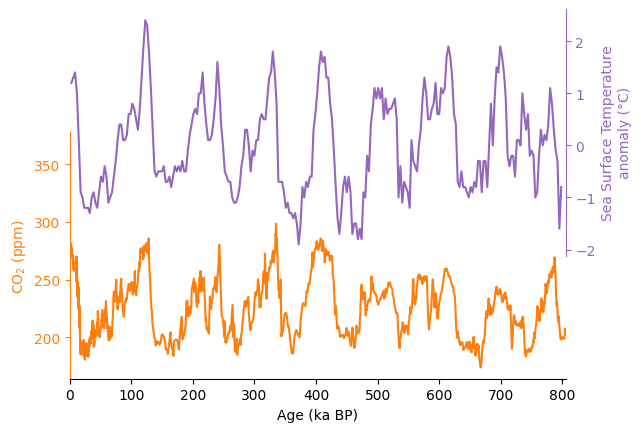

In [ ]:
# This code block will plot the CO2 and temperature data as two
# time series
# read SST data
SST = pd.read_table('/content/drive/Shareddrives/Academy/Courses/Climate/Climatematch/02-Curriculum/Climatematch Content Folder/W2D2 - Projects Day /Shakun2015_SST.txt')
SST.set_index('Age', inplace=True)

# read CO2 data
CO2 = pd.read_table('/content/drive/Shareddrives/Academy/Courses/Climate/Climatematch/02-Curriculum/Climatematch Content Folder/W2D2 - Projects Day /antarctica2015co2composite_cleaned.txt')
CO2.set_index('age_gas_calBP', inplace=True)

#%% plot
# set up two subplots in a grid of 2 rows and 1 column
# also make sure the two plots share the same x(time) axis
fig, axes = plt.subplots(2, 1, sharex=True)
# move the two subplots closer to each other
fig.subplots_adjust(hspace=-0.5)
axes[0].plot(SST.index, SST['SST stack'], color='C4')
axes[1].plot(CO2.index/1000, CO2['co2_ppm'], color='C1')

#%% beautification
# since sharex=True in plt.subplots(), this sets the x axis limit for both panels
axes[1].set_xlim((0, 805))
# axis labels
axes[1].set_xlabel('Age (ka BP)')
axes[0].set_ylabel(r'Sea Surface Temperature'
                   '\n'
                   'anomaly (°C)',
                   color='C4')
axes[1].set_ylabel(r'CO${}_\mathrm{2}$ (ppm)',
                   color='C1')
# despine makes the plots look cleaner
sns.despine(ax=axes[0], top=True, right=False, bottom=True, left=True)
sns.despine(ax=axes[1], top=True, right=True, bottom=False, left=False)
# clean up top panel x axis ticks
axes[0].xaxis.set_ticks_position('none')
# move top panel xlabel to the right side
axes[0].yaxis.set_label_position('right')
# the following code ensures the subplots don't overlap
for ax in axes:
    ax.set_zorder(10)
    ax.set_facecolor('none')
# color the axis
axes[0].spines['right'].set_color('C4')
axes[1].spines['left'].set_color('C1')
axes[0].tick_params(axis='y', colors='C4')
axes[1].tick_params(axis='y', colors='C1')

Now that we've taken a look at the two time series, let's make a scatter plot between them and fit a linear regression model through the data.

Text(0, 0.5, 'Sea Surface Temperature\ndetrended (°C)')

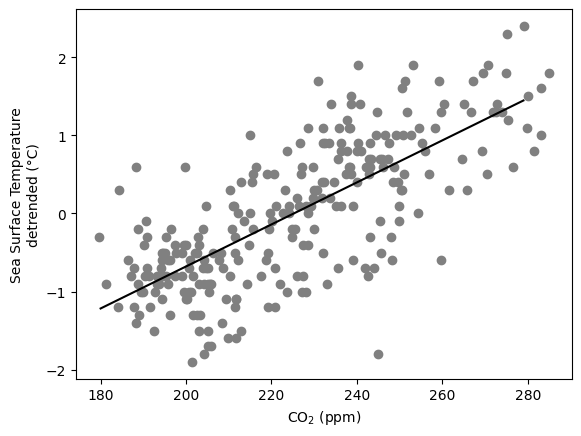

In [ ]:
# In this code block, we will make a scatter plot of CO2 and temperature
# and fit a linear regression model through the data

def age_model_interp(CO2_age, CO2, SST_age):
  '''
  This helper function linearly interpolates CO2 data, which
  have a very high temporal resolution, to temperature data,
  which have a relatively low resolution
  '''
  f = interpolate.interp1d(CO2_age, CO2, fill_value='extrapolate')
  all_ages = f(SST_age)
  return all_ages

# read SST data
SST = pd.read_table('/content/drive/Shareddrives/Academy/Courses/Climate/Climatematch/02-Curriculum/Climatematch Content Folder/W2D2 - Projects Day /Shakun2015_SST.txt')
SST.set_index('Age', inplace=True)

# read CO2 data
CO2 = pd.read_table('/content/drive/Shareddrives/Academy/Courses/Climate/Climatematch/02-Curriculum/Climatematch Content Folder/W2D2 - Projects Day /antarctica2015co2composite_cleaned.txt')
CO2.set_index('age_gas_calBP', inplace=True)

# interpolate CO2 data to SST age
CO2_interpolated = age_model_interp(CO2.index/1000, CO2['co2_ppm'], SST.index)

#%% plot
# set up two subplots in a grid of 2 rows and 1 column
# also make sure the two plots share the same x(time) axis
fig, ax = plt.subplots(1, 1, sharex=True)

ax.scatter(CO2_interpolated, SST['SST stack'], color='gray')

#%% regression
X = CO2_interpolated
X = sm.add_constant(X)  # let's add an intercept (beta_0) to our model
y = SST['SST stack']
mod = sm.OLS(y, X)    # ordinary least sqaure
res = mod.fit()       # Fit model
# print(res.summary())   # Summarize model
x_fit = np.arange(180, 280)
# res.params[1] returns the slope of the fit line and res.params[0] is the
# intercept
y_fit = x_fit * res.params[1] + res.params[0]
ax.plot(x_fit, y_fit, color='k')

#%% beautification
# axis labels
ax.set_xlabel(r'CO${}_\mathrm{2}$ (ppm)')
ax.set_ylabel(r'Sea Surface Temperature'
                    '\n'
                    'detrended (°C)')


**Figure making through the equity lense**
<details>
<summary>Click here for some information</summary>
Are the colors in your figure distinguishable for people with color-vision deficiencies?

More readings on this topic:

Contrast checker: https://www.color-blindness.com/coblis-color-blindness-simulator/

Coloring for color blindness: https://davidmathlogic.com/colorblind

Python-specific color palettes that are friendly to those with color-vision deficiency: https://seaborn.pydata.org/tutorial/color_palettes.html